In [9]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import sys
from gerrychain import Graph, GeographicPartition, Partition, Election, accept
from gerrychain.updaters import Tally, cut_edges
import seaborn as sns

In [2]:
df = gpd.read_file("GA_precincts16/GA_precincts16.shp")

In [19]:
df.head()

,ID,POPULATION,DISTRICT,PRECINCT_I,PRECINCT_N,CTYNAME,FIPS1,FIPS2,PRES16D,PRES16R,...,NHPIVAP,OTHERVAP,2MOREVAP,CONDIST,HDIST,SENDIST,geometry,BVAP_perc,HVAP_perc,nWVAP_perc
0,6094217,1013,073131,131,JOURNEY COMM. CHURCH,Columbia,13073,073,107,459,...,0,0,7,012,122,024,"POLYGON ((-82.14546199999999 33.57854, -82.145...",0.049322,0.004932,0.072750
1,6094266,3858,073064,064,GRACE BAPTIST CHURCH,Columbia,13073,073,767,1334,...,5,3,32,010,122,024,"POLYGON ((-82.16342400000001 33.574227, -82.16...",0.219492,0.033989,0.321048
2,6094297,1920,073061,061,GREENBRIER HIGH,Columbia,13073,073,387,1393,...,0,1,9,010,122,024,"POLYGON ((-82.16580999999999 33.564983, -82.16...",0.068128,0.014096,0.116680
3,6094341,1770,073063,063,RIVERSIDE ELEMENTARY,Columbia,13073,073,267,624,...,0,3,15,012,122,024,"POLYGON ((-82.139089 33.575924, -82.139141 33....",0.122570,0.041420,0.204565
4,6094377,3131,073132,132,WESLEY METHODIST,Columbia,13073,073,452,1377,...,3,1,21,012,122,024,"POLYGON ((-82.14330200000001 33.573481, -82.14...",0.084152,0.023067,0.168731


In [4]:
df.columns

Index(['ID', 'POPULATION', 'DISTRICT', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'FIPS1', 'FIPS2', 'PRES16D', 'PRES16R', 'PRES16L', 'SEN16D', 'SEN16R',
       'SEN16L', 'TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN',
       'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'HISP', 'H_WHITE', 'H_BLACK',
       'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP',
       'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP', 'CONDIST', 'HDIST', 'SENDIST', 'geometry'],
      dtype='object')

In [14]:
df["BVAP_perc"] = (df["BVAP"] / df["VAP"]).fillna(0)
df["HVAP_perc"] = (df["HVAP"] / df["VAP"]).fillna(0)
df["nWVAP_perc"] = (1 - (df["WVAP"] / df["VAP"])).fillna(0)

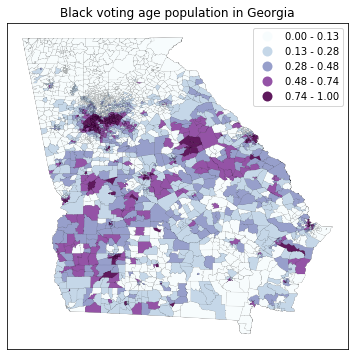

In [65]:
fig = df.plot(color="None", linewidth=0.25, edgecolor='k', figsize=(10,6))

df.plot(linestyle="None", column="BVAP_perc", ax=fig, alpha=0.9,
            cmap="BuPu", legend=True,figsize=(10,6), scheme="naturalbreaks", )
#             classification_kwds = {"bins": [0.1, 0.3, 0.5, 0.75, 1]})
fig.set_title("Black voting age population in Georgia")
fig.get_xaxis().set_visible(False)
fig.get_yaxis().set_visible(False)
plt.savefig("plots/choropleths/GA_choropleth_BVAP.png", bbox_inches="tight", dpi=200)
plt.show()

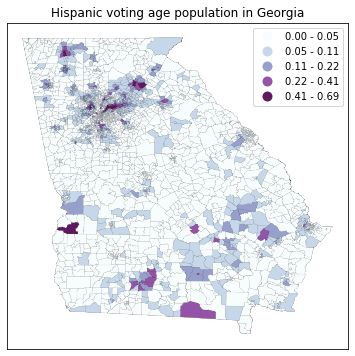

In [66]:
fig = df.plot(color="None", linewidth=0.25, edgecolor='k', figsize=(10,6))

df.plot(linestyle="None", column="HVAP_perc", ax=fig, alpha=0.9,
            cmap="BuPu", legend=True,figsize=(10,6), scheme="naturalbreaks", )
#             classification_kwds = {"bins": [0.15, 0.2, 0.3, 0.5, 1]})
fig.set_title("Hispanic voting age population in Georgia")
fig.get_xaxis().set_visible(False)
fig.get_yaxis().set_visible(False)
plt.savefig("plots/choropleths/GA_choropleth_HVAP.png", bbox_inches="tight", dpi=200)
plt.show()

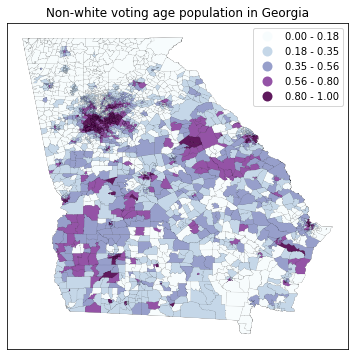

In [67]:
fig = df.plot(color="None", linewidth=0.25, edgecolor='k', figsize=(10,6))

df.plot(linestyle="None", column="nWVAP_perc", ax=fig, alpha=0.9,
            cmap="BuPu", legend=True,figsize=(10,6), scheme="naturalbreaks", )
#             classification_kwds = {"bins": [0.15, 0.2, 0.3, 0.5, 1]})
fig.set_title("Non-white voting age population in Georgia")
fig.get_xaxis().set_visible(False)
fig.get_yaxis().set_visible(False)
plt.savefig("plots/choropleths/GA_choropleth_nWVAP.png", bbox_inches="tight", dpi=200)
plt.show()

In [75]:
atl = pd.concat([df.loc[df.FIPS2 == "063"], # Clayton
                 df.loc[df.FIPS2 == "067"], # Cobb
                 df.loc[df.FIPS2 == "089"], # DeKalb
                 df.loc[df.FIPS2 == "121"], # Fulton
                 df.loc[df.FIPS2 == "135"], # Gwinnett
                 df.loc[df.FIPS2 == "247"], # Rockdale
                 df.loc[df.FIPS2 == "113"], # Fayette
                 df.loc[df.FIPS2 == "097"], # Douglas
                 df.loc[df.FIPS2 == "117"], # Forsyth
                 df.loc[df.FIPS2 == "151"], # Henry
                 df.loc[df.FIPS2 == "057"], # Cherokee
                 df.loc[df.FIPS2 == "255"], # Spalding
                 df.loc[df.FIPS2 == "013"], # Barrow
                 df.loc[df.FIPS2 == "223"], # Paulding
                 df.loc[df.FIPS2 == "297"], # Walton
                 df.loc[df.FIPS2 == "217"], # Newton
                 df.loc[df.FIPS2 == "015"], # Bartow
                 df.loc[df.FIPS2 == "077"], # Coweta
                 df.loc[df.FIPS2 == "045"], # Carrol
                 df.loc[df.FIPS2 == "227"], # Pickens
                 df.loc[df.FIPS2 == "035"], # Butts
                 df.loc[df.FIPS2 == "139"], # Hall
                ])


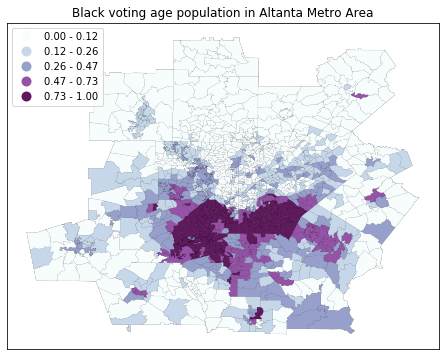

In [76]:
fig = atl.plot(color="None", linewidth=0.25, edgecolor='k', figsize=(10,6))
atl.plot(linestyle="None", column="BVAP_perc", ax=fig, alpha=0.9,
         legend_kwds={'loc': 'upper left'},
         cmap="BuPu", legend=True,figsize=(10,6), scheme="naturalbreaks", )
#             classification_kwds = {"bins": [0.15, 0.2, 0.3, 0.5, 1]})
fig.set_title("Black voting age population in Altanta Metro Area")
fig.get_xaxis().set_visible(False)
fig.get_yaxis().set_visible(False)
plt.savefig("plots/choropleths/ATL_choropleth_BVAP.png", bbox_inches="tight", dpi=200)
plt.show()

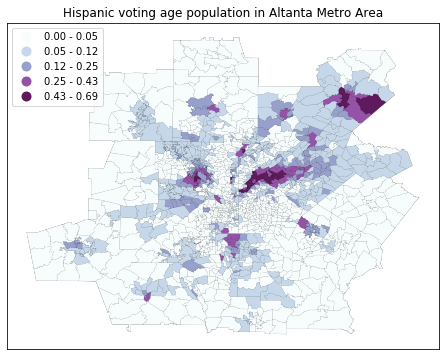

In [77]:
fig = atl.plot(color="None", linewidth=0.25, edgecolor='k', figsize=(10,6))

atl.plot(linestyle="None", column="HVAP_perc", ax=fig, alpha=0.9,
         legend_kwds={'loc': 'upper left'},
         cmap="BuPu", legend=True,figsize=(10,6), scheme="naturalbreaks", )
#             classification_kwds = {"bins": [0.15, 0.2, 0.3, 0.5, 1]})
fig.set_title("Hispanic voting age population in Altanta Metro Area")
fig.get_xaxis().set_visible(False)
fig.get_yaxis().set_visible(False)
plt.savefig("plots/choropleths/ATL_choropleth_HVAP.png", bbox_inches="tight", dpi=200)
plt.show()

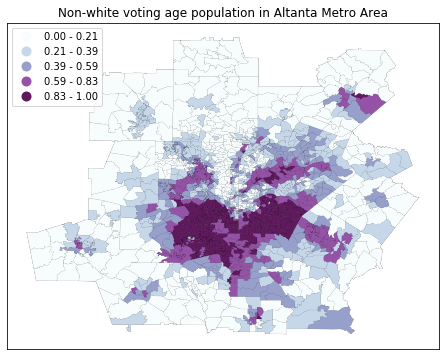

In [78]:
fig = atl.plot(color="None", linewidth=0.25, edgecolor='k', figsize=(10,6))

atl.plot(linestyle="None", column="nWVAP_perc", ax=fig, alpha=0.9,
         legend_kwds={'loc': 'upper left'},
         cmap="BuPu", legend=True,figsize=(10,6), scheme="naturalbreaks", )
#             classification_kwds = {"bins": [0.15, 0.2, 0.3, 0.5, 1]})
fig.set_title("Non-white voting age population in Altanta Metro Area")
fig.get_xaxis().set_visible(False)
fig.get_yaxis().set_visible(False)
plt.savefig("plots/choropleths/ATL_choropleth_nWVAP.png", bbox_inches="tight", dpi=200)
plt.show()